In [117]:
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import scipy
from scipy.stats import chi2

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from scipy import stats
import xgboost as xgb
from sklearn.metrics import auc,roc_curve,roc_auc_score

#import graphviz
%matplotlib inline 

In [96]:
import os
os.chdir(r'E:\AnalystPersonal\chenxiaoyan\催收\催收929\xgboost')

## 导入数据

In [706]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
oot = pd.read_csv('oot.csv')

In [5]:
train_df.groupby('default').count()

,Unnamed: 0,id,zl,o_total_amount,dpd,monthly_payment,remain_phases,o_penalty,o_forfeit,contract_amount,...,marriage_age_status_141,marriage_age_status_211,marriage_age_status_221,marriage_age_status_231,marriage_age_status_241,marriage_age_status_311,marriage_age_status_321,marriage_age_status_331,marriage_age_status_341,marriage_age_status_nan
default,,,,,,,,,,,,,,,,,,,,,
0,511569,511569,511569,511569,511569,511569,511569,511569,511569,511569,...,511569,511569,511569,511569,511569,511569,511569,511569,511569,511569
1,7904,7904,7904,7904,7904,7904,7904,7904,7904,7904,...,7904,7904,7904,7904,7904,7904,7904,7904,7904,7904


In [24]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':4,  #树的最大深度 需要cv来进行调优
    'subsample':0.7, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.7, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':10000, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    'eta': 0.2, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    'lambda':1, #l2 
    'alpha':1, #l1
    'eval_metric': 'auc'  # 度量方式
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f' % (gini, ks, accuracy,precision,recall))
    print('confusion matrix:')
    print(cm)
X_train = train_df.drop(['default'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_df.default)
xgb_test = xgb.DMatrix(test_df[X_train.columns],label=test_df.default)

xgb_oot = xgb.DMatrix(oot[X_train.columns],label=oot.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds, train_df.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2, test_df.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3, oot.default)


C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.84955	test-auc:0.851129
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[1]	train-auc:0.865212	test-auc:0.864431
[2]	train-auc:0.86826	test-auc:0.866678
[3]	train-auc:0.873716	test-auc:0.874842
[4]	train-auc:0.874541	test-auc:0.876743
[5]	train-auc:0.876105	test-auc:0.878069
[6]	train-auc:0.876346	test-auc:0.878512
[7]	train-auc:0.87893	test-auc:0.878228
[8]	train-auc:0.880036	test-auc:0.880601
[9]	train-auc:0.879922	test-auc:0.879385
[10]	train-auc:0.878935	test-auc:0.877991
[11]	train-auc:0.878901	test-auc:0.876963
[12]	train-auc:0.878901	test-auc:0.876963
[13]	train-auc:0.878901	test-auc:0.876963
[14]	train-auc:0.878901	test-auc:0.876963
[15]	train-auc:0.878901	test-auc:0.876963
[16]	train-auc:0.878901	test-auc:0.876963
[17]	train-auc:0.878901	test-auc:0.876963
[18]	train-auc:0.878901	test-auc:0.876963
[19]	train-auc:0.878901	test-auc:0.876963
[20]	train-auc:0.878901	test-auc

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.75780 	 KS is: 0.65773 	 accuracy: 0.98478 	 Precision: 0.00000 	 Recall:0.00000
confusion matrix:
[[511569      0]
 [  7904      0]]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.75393 	 KS is: 0.65531 	 accuracy: 0.98478 	 Precision: 0.00000 	 Recall:0.00000
confusion matrix:
[[127893      0]
 [  1976      0]]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.74091 	 KS is: 0.62515 	 accuracy: 0.98863 	 Precision: 0.00000 	 Recall:0.00000
confusion matrix:
[[640014      0]
 [  7360      0]]


## 调用全账龄模型

In [701]:
from sklearn.externals import joblib
booster= joblib.load(r'model_final_190628.m')

In [702]:
booster

In [703]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 9
self_FR_get_SR_get_prop_6m    3
self_FR_get_SR_get_prop_tt    2
recent_first_days             2
fp_camt_pct                   2
o_interest                    1
dtype: int64

In [707]:
X_train = train_df.drop(['default'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_df.default)
xgb_test = xgb.DMatrix(test_df[X_train.columns],label=test_df.default)
xgb_oot = xgb.DMatrix(oot[X_train.columns],label=oot.default)

In [1020]:
X_train

,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest
1,123,0.500000,0.500000,795,26.185332,5193.63
2,918,0.000000,0.000000,427,27.052476,1213.28
3,690,0.000000,0.000000,273,18.897241,3224.60
4,152,0.000000,0.000000,158,3.785940,3596.70
5,1384,0.000000,0.000000,7,58.830162,7887.30
8,233,1.000000,1.000000,212,5.606728,3108.15
10,1412,1.000000,1.000000,278,21.334045,5317.00
11,607,0.000000,0.000000,486,27.898197,5995.59
12,280,1.000000,1.000000,0,7.522994,3766.77
13,1329,0.000000,0.000000,274,28.658374,1401.19


In [708]:
preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds, train_df.default)
report_performance(preds2, test_df.default)
report_performance(preds3, oot.default)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.75275 	 KS is: 0.65659 	 accuracy: 0.98478 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.87637
confusion matrix:
[[511569      0]
 [  7904      0]]
=======================report=================
Gini is: 0.75663 	 KS is: 0.65473 	 accuracy: 0.98478 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.87831
confusion matrix:
[[127893      0]
 [  1976      0]]
=======================report=================
Gini is: 0.73755 	 KS is: 0.62309 	 accuracy: 0.98863 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.86877
confusion matrix:
[[640014      0]
 [  7360      0]]


In [709]:
preds

array([0.11666206, 0.12137004, 0.09758081, ..., 0.09761325, 0.09985643,
       0.10506577], dtype=float32)

In [768]:
#分数转化
def score_ys(datain,p,PDO,basepoint):
    cs=np.log(p/(1-p))
    B=PDO/np.log(2)
    A=basepoint+B*np.log(1/50)
    score=np.round(A-cs*B)
    datain['score'] = score
    datain['p']=p

In [711]:
score_ys(train_df,preds,50,500)

In [712]:
def plot_psi(actual,expected,title = 'PSI',quant=20):
    minv = min(min(actual),min(expected))
    maxv = max(max(actual),max(expected))
    step = 1.0*(maxv-minv)/quant
    acnt = []
    ecnt = []
    s,e = minv,minv+step
    act = np.array(actual)
    ex = np.array(expected)

    while e <= maxv:
        acnt.append(((act>=s) & (act < e)).sum())
        ecnt.append(((ex>=s )& (ex < e)).sum())
        s = e
        e = e+step

    arate = np.array(acnt)/ len(actual)
    erate = np.array(ecnt)/ len(expected)

    arate[arate==0] = 0.000001
    erate[erate==0] = 0.000001

    psi = np.sum((arate - erate)*np.log(arate/erate))
    #psi = psi.sum()

    x1 = np.linspace(0,len(acnt)-1,len(acnt)) - 0.2
    x2 = np.linspace(0,len(acnt)-1,len(acnt)) + 0.2
    plt.bar(x1, arate*100, alpha=0.9, width = 0.4, facecolor = 'orange', edgecolor = 'white', label='Actual', lw=0.2)
    plt.bar(x2, erate*100, alpha=0.9, width = 0.4, facecolor = 'lightblue', edgecolor = 'white', label='Expected', lw=0.2)
    plt.legend()
    plt.suptitle(title)
    plt.title('({})'.format(psi))
    ax = plt.axes()
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))
    plt.show()
    return psi

In [713]:
def pct_rank_qcut(datain,series,n):
   
    """离散型变量分箱"""
    edages = pd.Series([i/n for i in range(n)]) #生成分位数
    
    func = lambda x:(edages >= x).idxmax() #argmax()返回最大值对应的索引,索引从0开始计算； func函数：输入x输出，输出百分位数对应的索引值
    datain[series + '_bin' ] = datain[series].rank(na_option = 'top',pct=True).astype(float).apply(func) 

In [714]:
 pct_rank_qcut(train_df,'score',10)

In [876]:
#统计分布
def score_fb(indata,var,var_bin):
    """连续型变量分箱"""
    score_fb = pd.DataFrame()
    g = indata[[var,var_bin,'default']].groupby(indata[var_bin])
    n = len(indata)
    good_n = len(indata[indata['default'].isin([0.0])])
    bad_n = len(indata[indata['default'].isin([1.0])])
    value_max = list(g.max()[var])
    value_min = list(g.min()[var])
    value = list(g.groups.keys())
    
    
    var_name = []
    bin_n = []
    bin_good_n = []
    bin_bad_n = []
    bin_rate = []
    bad_rate = []
    good_rate = []
    for i in range(0,len(g.groups)):
        var_name1 =var_bin
        bin_n1 = len(g.get_group(value[i]))
        bin_good_n1 = len(g.get_group(value[i])[g.get_group(value[i])['default'].isin([0.0])])
        bin_bad_n1 = len(g.get_group(value[i])[g.get_group(value[i])['default'].isin([1.0])])
        bin_rate1 = bin_n1/n
        bad_rate1 = bin_bad_n1/bin_n1
        good_rate1 = bin_good_n1/bin_n1
            
 
        bin_n.append(bin_n1)
        bin_good_n.append(bin_good_n1)
        bin_bad_n.append(bin_bad_n1)
        var_name.append(var_name1)
        bin_rate.append(bin_rate1)
        bad_rate.append(bad_rate1)
        good_rate.append(good_rate1)
             
    cols = ['var_name','value','value_min','value_max','bin_n','bin_good_n','bin_bad_n','bin_rate','bad_rate']
    num1 = pd.DataFrame(np.array([var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate]).T,columns =cols)
    score_fb= score_fb.append(num1,ignore_index=False)
    score_fb['qujian'] =  '['+score_fb['value_min']+','+score_fb['value_max']+']'
    score_fb['avg'] = indata['default'].value_counts(normalize=True)[1]
    score_fb = score_fb.sort_values('value_min')
    return score_fb

In [875]:
score_fb_ = score_fb(train_df,'score','score_bin')
score_fb_

,var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate,qujian,avg
0,score_bin,1,340.0,347.0,53817,48307,5510,0.10359922459877607,0.10238400505416505,"[340.0,347.0]",0.015215
1,score_bin,2,348.0,370.0,45637,44657,980,0.08785249666488923,0.021473804150141333,"[348.0,370.0]",0.015215
2,score_bin,3,371.0,373.0,73410,72859,551,0.14131629555337813,0.00750578940198883,"[371.0,373.0]",0.015215
3,score_bin,4,374.0,377.0,48623,48391,232,0.09360062986911735,0.004771404479361619,"[374.0,377.0]",0.015215
4,score_bin,6,378.0,378.0,91372,91112,260,0.17589364606052674,0.002845510659720702,"[378.0,378.0]",0.015215
5,score_bin,9,379.0,379.0,206614,206243,371,0.3977377072533125,0.0017956188835219298,"[379.0,379.0]",0.015215


In [900]:
def plot_fb(datain,n):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig = plt.figure(figsize=(12,8))  
    ax1 = fig.add_subplot(111)
    ax1.plot(score_fb_['qujian'],score_fb_['bad_rate'].astype('float'),'or--',label = u'回款率')
    
    ax2 = ax1.twinx()  
    plt.bar(score_fb_['qujian'],score_fb_['bin_rate'].astype('float'),alpha=0.6,color='darkblue',label=u'评分分布')  
    ax2.set_ylim([0, n])
    plt.tick_params(labelsize=15)
    ax2.tick_params(labelsize=15)
    labels = ax1.get_xticklabels() + ax1.get_yticklabels() 
    #labels1= ax3.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    font2 = {'weight': 'normal',
         'size': 18}
    ax1.set_xlabel('评分区间',font2)
    ax1.set_ylabel('回款率',font2)
    ax2.set_ylabel('各评分区间客户占比',font2)
    
    plt.plot(score_fb_['qujian'],score_fb_['avg'].astype('float'),'ob--',label = u'平均回款率')
    # 设置图例并且设置图例的字体及大小
    font1 = {'family': 'SimHei',
         'weight': 'normal',
         'size': 15
         }#合并图例
    fig.legend(loc=1,bbox_to_anchor=(0.25,1),bbox_transform=ax1.transAxes,prop=font1)
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='y',alpha=0.4)
    plt.title("回款率随评分变化趋势（等深划分评分）",fontsize=25)
    plt.savefig('figure.png')
   
    return plt.show()
     

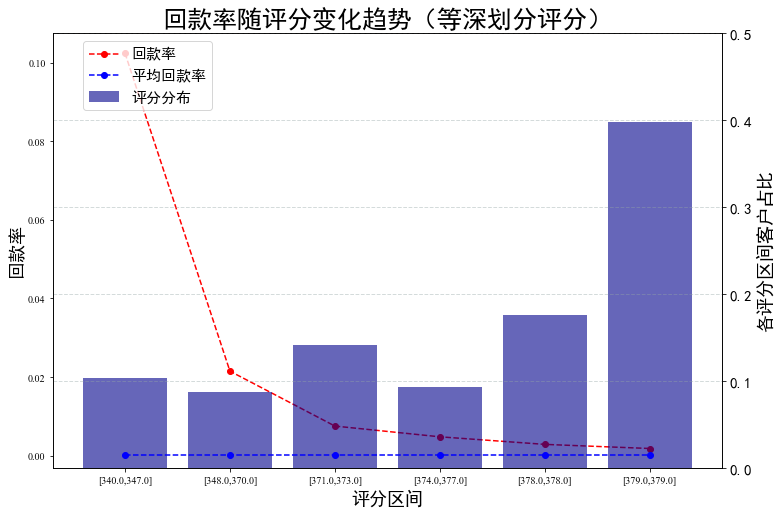

In [901]:
plot_fb(score_fb_,0.5)

### 分账龄计算KS

In [721]:
#分账龄计算KS
train_m12 = train_df1[train_df1['zl'].isin([1,2])][['zl','default','p']]
train_m36 = train_df1[train_df1['zl'].isin ([3,4,5,6])][['zl','default','p']]
train_m7 = train_df1[train_df1['zl']>6][['zl','default','p']]

test_m12 = test_df1[test_df1['zl'].isin([1,2])][['zl','default','p']]
test_m36 = test_df1[test_df1['zl'].isin ([3,4,5,6])][['zl','default','p']]
test_m7 = test_df1[test_df1['zl']>6][['zl','default','p']]

oot_m12 = oot_df1[oot_df1['zl'].isin([1,2])][['zl','default','p']]
oot_m36 = oot_df1[oot_df1['zl'].isin ([3,4,5,6])][['zl','default','p']]
oot_m7 = oot_df1[oot_df1['zl']>6][['zl','default','p']]


def zl_ks(datain):
    ks = stats.ks_2samp(datain.p[datain.default==1],datain.p[datain.default!=1]).statistic
    return ks

print(zl_ks(train_m12),zl_ks(test_m12),zl_ks(oot_m12),zl_ks(train_m36),zl_ks(test_m36),zl_ks(oot_m36),
      zl_ks(train_m7),zl_ks(test_m7),zl_ks(oot_m7),zl_ks(train_df1))


0.019312673080446766 0.015530419859704065 0.043206320328229214 0.3647391075975669 0.34687238128862935 0.3669746179147543 0.5165672778214736 0.5328404546660601 0.4969343884030578 0.656592060851484


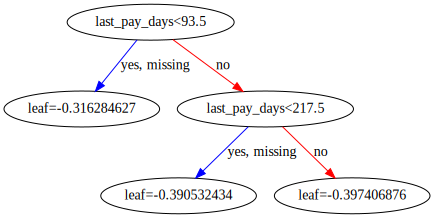

In [48]:
xgb.to_graphviz(booster,num_trees = 0)

In [65]:
train_leaf = booster.predict(xgb_train,pred_leaf=True,ntree_limit = booster.best_ntree_limit)
train_leaf[0:1]

array([[3, 4, 1, 2, 4, 4, 1, 2]])

In [61]:
booster.dump_model

<bound method Booster.dump_model of <xgboost.core.Booster object at 0x000000000BDBF908>>

In [71]:
#计算概率值
train_df1[['last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest','p']][0:1]

,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,p
0,152,1.0,1.0,462,1.576903,560.45,0.116662


In [72]:
x = -0.390532434 + -0.319634855 + -0.242362902 + -0.268885463 + -0.247011706 + -0.23480241 + -0.157141611 + -0.164055228
p = 1/(1+np.exp(-x))
p

0.1166620452709211

## 分账龄建模 - m1-m2 - 使用相同变量

In [989]:
#分账龄建模 - m1-m2 - 使用相同变量
train_m12 = train_df[train_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m12 = test_df[test_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m12 = oot[oot['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
print(train_m12.shape,test_m12.shape,oot_m12.shape)
print(train_m12['default'].value_counts(normalize=True),test_m12['default'].value_counts(normalize=True),oot_m12['default'].value_counts(normalize=True))


(26014, 10) (6499, 10) (16816, 10)
0    0.857577
1    0.142423
Name: default, dtype: float64 0    0.860902
1    0.139098
Name: default, dtype: float64 0    0.858825
1    0.141175
Name: default, dtype: float64


In [1021]:
train_m12

,default,zl,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,o_total_amount,return_amt
6,0,1,37,1.000000,1.000000,516,0.128886,279.56,4635.24,NaN
17,0,2,80,1.000000,1.000000,488,0.925753,233.22,4885.41,NaN
57,0,2,64,1.000000,1.000000,428,0.168351,1630.42,19530.17,NaN
63,0,2,2,1.000000,1.000000,308,0.279319,1430.86,6467.35,NaN
103,0,1,52,1.000000,1.000000,273,0.114459,1066.59,4735.01,NaN
120,0,1,42,1.000000,1.000000,28,0.144436,910.39,4493.69,NaN
149,0,2,80,1.000000,1.000000,427,0.399379,1502.40,10746.85,NaN
169,0,1,52,0.000000,0.000000,28,0.059486,1429.91,6922.96,NaN
197,0,2,78,1.000000,1.000000,339,0.491263,1554.35,7864.31,34.12
220,1,2,2,1.000000,1.000000,354,0.167621,525.00,4173.59,4100.00


In [1001]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':3,  #树的最大深度 需要cv来进行调优
    'subsample':0.7, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.7, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':500, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    'eta': 0.01, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    'lambda':2, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    'gamma':0.15
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m12.drop(['default','zl','o_total_amount','return_amt'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m12.default)
xgb_test = xgb.DMatrix(test_m12[X_train.columns],label=test_m12.default)

xgb_oot = xgb.DMatrix(oot_m12[X_train.columns],label=oot_m12.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m12.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m12.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m12.default)


[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.558955	test-auc:0.550004
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.62697	test-auc:0.620286
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.627083	test-auc:0.61935
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.62808	test-auc:0.618863
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[42]	train-auc:0.650157	test-auc:0.634836
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[43]	train-auc:0.650005	test-auc:0.634686
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[44]	train-auc:0.649976	test-auc:0.634822
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[45]	train-auc:0.6501	test-auc:0.634969
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[46]	train-auc:0.650525	test-auc:0.635273
[14:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[47]	train-auc:0.650943	test-auc:0.63576

[85]	train-auc:0.650065	test-auc:0.635434
[14:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[86]	train-auc:0.649965	test-auc:0.635412
[14:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[87]	train-auc:0.650257	test-auc:0.635785
[14:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[88]	train-auc:0.650313	test-auc:0.63564
[14:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[89]	train-auc:0.650186	test-auc:0.635524
[14:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[90]	train-auc:0.650095	test-auc:0.63542

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [991]:
from sklearn.externals import joblib
joblib.dump(booster,r'm12.m')

['m12.m']

In [1002]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days        146
recent_first_days    121
fp_camt_pct           90
o_interest            31
dtype: int64

In [1003]:
booster.dump_model('dump.raw.txt')

In [926]:
preds2

array([0.32545993, 0.29835862, 0.35589793, ..., 0.28686112, 0.2860908 ,
       0.31358737], dtype=float32)

In [928]:
score_ys(train_m12,preds,50,500)
score_ys(test_m12,preds2,50,500)
score_ys(oot_m12,preds3,50,500)

In [753]:
pct_rank_qcut(train_m12,'score',10)

In [754]:
score_fb_ = score_fb(train_m12,'score','score_bin')

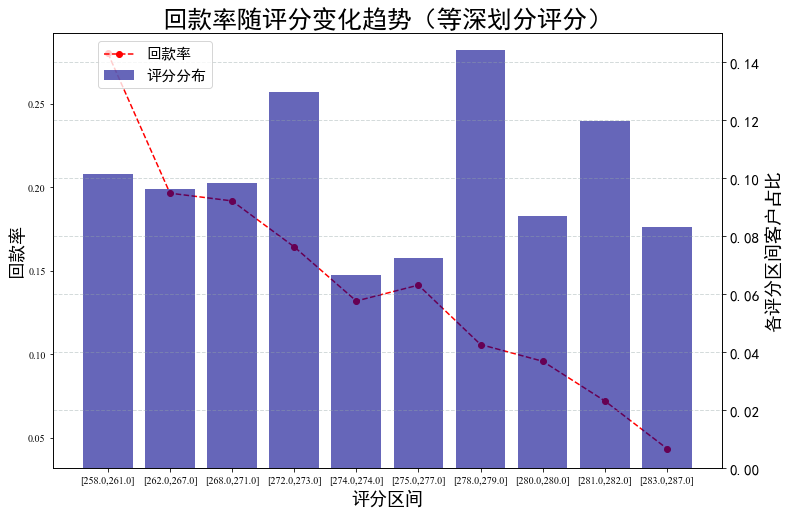

In [746]:
plot_fb(score_fb_,0.15)

## 分账龄建模 - m1-m2 - 使用全部变量

In [156]:
#分账龄建模 - m1-m2 - 使用全部变量
train_m12 = train_df[train_df['zl'].isin([1,2])].drop(['id','zl','return_amt','o_total_amount1'],axis = 1)
test_m12 = test_df[test_df['zl'].isin([1,2])].drop(['id','zl','return_amt','o_total_amount1'],axis = 1)
oot_m12 = oot[oot['zl'].isin([1,2])].drop(['id','zl','return_amt','o_total_amount1'],axis = 1)
print(train_m12.shape,test_m12.shape,oot_m12.shape)

(26014, 220) (6499, 221) (16816, 222)


In [159]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':2,  #树的最大深度 需要cv来进行调优
    #'subsample':0.7, # 这个参数控制对于每棵树，随机采样的比例。
    #'colsample_bytree':0.7, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':230, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    #'eta': 0.01, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    #'lambda':2, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    #'gamma':0.15
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m12.drop(['default'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m12.default)
xgb_test = xgb.DMatrix(test_m12[X_train.columns],label=test_m12.default)

xgb_oot = xgb.DMatrix(oot_m12[X_train.columns],label=oot_m12.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m12.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m12.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m12.default)


[09:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	train-auc:0.664254	test-auc:0.660816
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[09:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	train-auc:0.672817	test-auc:0.667374
[09:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	train-auc:0.675447	test-auc:0.670146
[09:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	train-auc:0.67623	test-auc:0.671139
[09:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[09:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[43]	train-auc:0.741646	test-auc:0.730886
[09:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[44]	train-auc:0.741359	test-auc:0.730015
[09:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[45]	train-auc:0.74197	test-auc:0.73079
[09:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[46]	train-auc:0.742336	test-auc:0.730302
[09:54:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[47]	train-auc:0.743217	test-auc:0.731352
[09:54:33] C:\Users\Administrator\Desktop\

[85]	train-auc:0.752928	test-auc:0.736629
[09:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[86]	train-auc:0.753215	test-auc:0.736852
[09:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[87]	train-auc:0.753249	test-auc:0.736431
[09:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[88]	train-auc:0.753661	test-auc:0.737366
[09:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[89]	train-auc:0.753427	test-auc:0.737209
[09:54:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[90]	train-auc:0.753887	test-auc:0.73791

[09:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[129]	train-auc:0.760115	test-auc:0.741057
[09:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[130]	train-auc:0.759979	test-auc:0.740418
[09:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[131]	train-auc:0.760328	test-auc:0.74063
[09:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[132]	train-auc:0.760298	test-auc:0.74019
[09:54:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[133]	train-auc:0.760762	test-auc:0.740693
[09:54:35] C:\Users\Administrator\Des

In [659]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 46
recent_first_days             33
fp_camt_pct                   20
zl                             9
o_interest                     8
self_FR_get_SR_get_prop_tt     4
dtype: int64

##  分账龄建模 - m3-m6 - 使用相同变量

In [992]:
#分账龄建模 - m3-m6 - 使用相同变量
train_m36 = train_df[train_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m36 = test_df[test_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m36 = oot[oot['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [758]:
print(train_m36.shape,test_m36.shape,oot_m36.shape)
print(train_m36['default'].value_counts(normalize=True),test_m36['default'].value_counts(normalize=True),oot_m36['default'].value_counts(normalize=True))

(49978, 10) (12677, 10) (59452, 10)
0    0.97711
1    0.02289
Name: default, dtype: float64 0    0.97602
1    0.02398
Name: default, dtype: float64 0    0.973811
1    0.026189
Name: default, dtype: float64


In [1004]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':3,  #树的最大深度 需要cv来进行调优
    'subsample':0.8, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.7, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':500, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    'eta': 0.3, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    #'lambda':3, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    'gamma':0.1
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m36.drop(['default','o_total_amount','return_amt','zl'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m36.default)
xgb_test = xgb.DMatrix(test_m36[X_train.columns],label=test_m36.default)

xgb_oot = xgb.DMatrix(oot_m36[X_train.columns],label=oot_m36.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m36.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m36.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m36.default)


[14:33:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	train-auc:0.727046	test-auc:0.720183
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[14:33:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	train-auc:0.746743	test-auc:0.724072
[14:33:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.767849	test-auc:0.740752
[14:33:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.774681	test-auc:0.749751
[14:33:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1005]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days        19
fp_camt_pct           8
recent_first_days     6
o_interest            4
dtype: int64

In [995]:
joblib.dump(booster,r'm36.m')

['m36.m']

In [1006]:
booster.dump_model('dump.raw.txt')

In [782]:
def score_ys(datain,p,PDO,basepoint):
    cs=np.log(p/(1-p))
    B=PDO/np.log(2)
    A=basepoint+B*np.log(1/50)
    score=np.round(A-cs*B)
    datain['score'] = score
    datain['p']=p
    #return datain['score']

In [934]:
preds

array([0.03229899, 0.0321746 , 0.03179419, ..., 0.03946028, 0.03794604,
       0.03909723], dtype=float32)

In [966]:
score_ys(train_m36,preds,50,500)
score_ys(test_m36,preds2,50,500)
score_ys(oot_m36,preds3,50,500)

In [785]:
pct_rank_qcut(train_m36,'score',10)

In [786]:
score_fb_ = score_fb(train_m36,'score','score_bin')
score_fb_

,var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate,qujian
1,score_bin,1,377.0,398.0,5184,4693,491,0.10372563928128377,0.09471450617283951,"[377.0,398.0]"
2,score_bin,2,400.0,435.0,5061,4853,208,0.10126455640481812,0.041098597115194625,"[400.0,435.0]"
3,score_bin,3,436.0,445.0,4553,4436,117,0.09110008403697627,0.025697342411596748,"[436.0,445.0]"
4,score_bin,4,446.0,451.0,4961,4875,86,0.09926367601744768,0.017335214674460794,"[446.0,451.0]"
5,score_bin,5,452.0,456.0,5107,5039,68,0.10218496138300852,0.013315057763853534,"[452.0,456.0]"
6,score_bin,6,457.0,459.0,5177,5120,57,0.10358557765416783,0.011010237589337455,"[457.0,459.0]"
7,score_bin,7,460.0,463.0,4567,4533,34,0.09138020729120813,0.007444712064812787,"[460.0,463.0]"
8,score_bin,8,464.0,468.0,6930,6874,56,0.1386610108447717,0.00808080808080808,"[464.0,468.0]"
9,score_bin,9,469.0,472.0,2308,2297,11,0.046180319340509826,0.004766031195840554,"[469.0,472.0]"
0,score_bin,0,473.0,473.0,6130,6114,16,0.12265396774580815,0.0026101141924959217,"[473.0,473.0]"


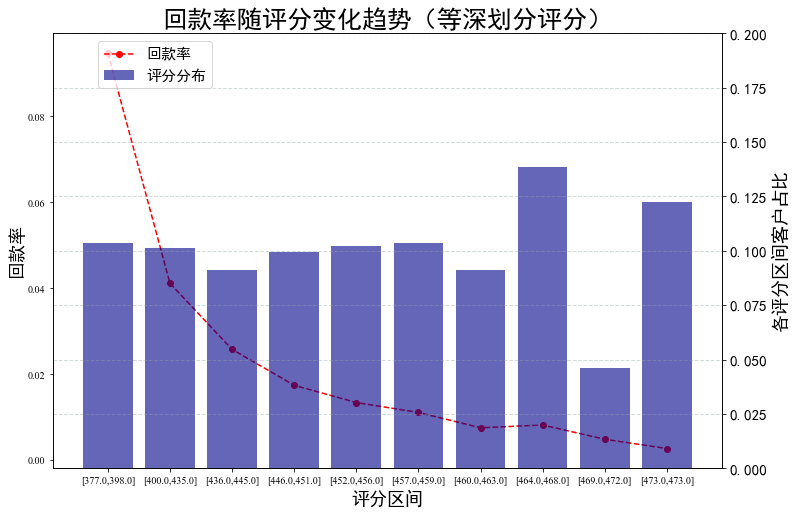

In [787]:
plot_fb(score_fb_,0.2)

## 分账龄建模 - m3-m6 - 使用全部变量

In [422]:
#分账龄建模 - m3-m6 - 使用全部变量
train_m36 = train_df[train_df['zl'].isin ([3,4,5,6])]
test_m36 = test_df[test_df['zl'].isin ([3,4,5,6])]
oot_m36 = oot[oot['zl'].isin ([3,4,5,6])]

In [423]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':3,  #树的最大深度 需要cv来进行调优
    'subsample':0.8, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.7, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':1100, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    'eta': 0.3, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    #'lambda':3, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    'gamma':0.1
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m36.drop(['default'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m36.default)
xgb_test = xgb.DMatrix(test_m36[X_train.columns],label=test_m36.default)

xgb_oot = xgb.DMatrix(oot_m36[X_train.columns],label=oot_m36.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m36.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m36.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m36.default)


[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	train-auc:0.77047	test-auc:0.76636
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.784863	test-auc:0.781953
[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.79231	test-auc:0.78006
[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	train-auc:0.795004	test-auc:0.787561
[10:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.61599 	 KS is: 0.49187 	 accuracy: 0.97381 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.80800
confusion matrix:
[[57895     0]
 [ 1557     0]]


In [424]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

self_FR_get_SR_get_prop_3m    3
return_avgpct_3m_nn           3
tot_retpct_6m                 2
fp_camt_pct                   2
zl                            1
tot_retpct_3m                 1
self_FR_get_SR_get_prop_1m    1
return_maxamt_6m              1
return_avgpct_3m              1
return_avgamt_6m              1
fp_monthpay_pct               1
dpd                           1
dtype: int64

In [425]:
score_ys(train_m36,preds,50,500)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0         395.0
7         386.0
9         392.0
30        395.0
31        381.0
43        377.0
44        395.0
46        386.0
53        390.0
62        393.0
76        386.0
77        390.0
81        391.0
91        391.0
95        386.0
99        343.0
126       343.0
128       388.0
132       384.0
137       393.0
144       386.0
160       384.0
164       383.0
194       343.0
199       387.0
200       395.0
214       384.0
216       391.0
236       380.0
239       393.0
          ...  
519170    383.0
519182    395.0
519183    393.0
519187    386.0
519195    343.0
519210    392.0
519212    343.0
519219    393.0
519224    395.0
519225    379.0
519235    395.0
519236    384.0
519239    395.0
519268    386.0
519273    388.0
519278    386.0
519289    343.0
519330    395.0
519333    390.0
519338    389.0
519340    391.0
519344    393.0
519353    393.0
519357    393.0
519368    395.0
519414    395.0
519417    395.0
519424    393.0
519427    381.0
519463    391.0
Name: score, Length: 499

In [426]:
pct_rank_qcut(train_m36,'score',10)

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 分账龄建模 - m7+ - 使用相同变量

In [996]:
#分账龄建模 - m7+ - 使用相同变量
train_m7 = train_df[train_df1['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m7 = test_df[test_df1['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m7 = oot[oot_df1['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [794]:
print(train_m7.shape,test_m7.shape,oot_m7.shape)
print(train_m7['default'].value_counts(normalize=True),test_m7['default'].value_counts(normalize=True),oot_m7['default'].value_counts(normalize=True))

(443481, 10) (110693, 10) (571106, 10)
0    0.993111
1    0.006889
Name: default, dtype: float64 0    0.993062
1    0.006938
Name: default, dtype: float64 0    0.993996
1    0.006004
Name: default, dtype: float64


In [1]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':3,  #树的最大深度 需要cv来进行调优
    'subsample':0.6, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.6, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':500, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    #'eta': 0.21, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    'lambda':1, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    'gamma':0.1
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m7.drop(['default','o_total_amount','return_amt','zl'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m7.default)
xgb_test = xgb.DMatrix(test_m7[X_train.columns],label=test_m7.default)

xgb_oot = xgb.DMatrix(oot_m7[X_train.columns],label=oot_m7.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m7.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m7.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m7.default)


NameError: name 'train_m7' is not defined

In [1010]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 41
recent_first_days             28
self_FR_get_SR_get_prop_6m    15
fp_camt_pct                   15
self_FR_get_SR_get_prop_tt    14
o_interest                    12
dtype: int64

In [1008]:
booster.dump_model('dump.raw.txt')

In [998]:
joblib.dump(booster,r'm7.m')

['m7.m']

In [940]:
preds3

array([0.00303409, 0.00187012, 0.01591994, ..., 0.00337426, 0.00146783,
       0.00156623], dtype=float32)

In [938]:
score_ys(train_m7,preds,50,500)
score_ys(test_m7,preds2,50,500)
score_ys(oot_m7,preds3,50,500)

In [803]:
pct_rank_qcut(train_m7,'score',10)

In [804]:
score_fb_ = score_fb(train_m7,'score','score_bin')
score_fb_

,var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate,qujian
1,score_bin,1,267.0,563.0,44705,42791,1914,0.10080476953916853,0.042814002907952134,"[267.0,563.0]"
2,score_bin,2,564.0,601.0,43533,43255,278,0.09816204076386587,0.006385960076263983,"[564.0,601.0]"
3,score_bin,3,602.0,625.0,44862,44633,229,0.10115878696043348,0.005104542820204182,"[602.0,625.0]"
4,score_bin,4,626.0,640.0,44670,44519,151,0.10072584845799482,0.0033803447503917617,"[626.0,640.0]"
5,score_bin,5,641.0,651.0,40753,40640,113,0.09189345203063942,0.0027728020023065785,"[641.0,651.0]"
6,score_bin,6,652.0,662.0,52485,52356,129,0.11834779844006846,0.0024578450985996,"[652.0,662.0]"
7,score_bin,7,663.0,671.0,41118,41051,67,0.09271648616287959,0.0016294566856364608,"[663.0,671.0]"
8,score_bin,8,672.0,677.0,44192,44112,80,0.09964801197796523,0.0018102824040550326,"[672.0,677.0]"
9,score_bin,9,678.0,679.0,10291,10283,8,0.023205052753105544,0.0007773782917112039,"[678.0,679.0]"
0,score_bin,0,680.0,692.0,76872,76786,86,0.17333775291387907,0.0011187428452492454,"[680.0,692.0]"


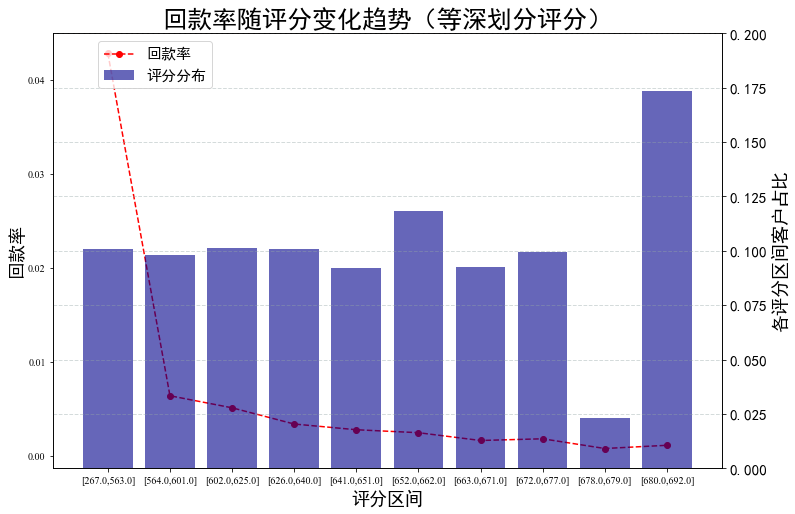

In [805]:
plot_fb(score_fb_,0.2)

## 分账龄建模 - m7+ - 使用全部变量

In [467]:
#分账龄建模 - m7+ - 使用全部变量
train_m7 = train_df[train_df1['zl']>6].drop(['return_amt','o_total_amount1'],axis = 1)
test_m7 = test_df[test_df1['zl']>6].drop(['return_amt','o_total_amount1'],axis = 1)
oot_m7 = oot[oot_df1['zl']>6].drop(['return_amt','o_total_amount1'],axis = 1)

In [468]:
#
params={
    'booster':'gbtree', #基于树的模型  gbliner:线性模型
    'objective': 'binary:logistic',   # 学习的目标函数  softmax  
    'max_depth':4,  #树的最大深度 需要cv来进行调优
    'subsample':0.6, # 这个参数控制对于每棵树，随机采样的比例。
    'colsample_bytree':0.6, #用来控制每棵随机采样的列数的占比(每一列是一个特征)。
    'min_child_weight':200, #叶子节点最小的样本数 这个参数用于避免过拟合。当它的较大时，可以避免模型学习到局部的特殊样本。但是如果这个值过高，会导致欠拟合。这个参数需要使用CV来调整
    'silent':0,  #是否静默  参数为1时不会输出任何信息
    #'eta': 0.21, # 通过减少每一步的权重，可以提高模型的鲁棒性。 一般默认0.01-0.2
    'seed':100, 
    'nthread':7, #线程数，输入系统的核数 如果不输入则使用cpu
    'lambda':1, #l2 
    #'alpha':1, #l1
    'eval_metric': 'auc' , # 度量方式
    'gamma':0.1
}



def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)
    
X_train = train_m7.drop(['default'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m7.default)
xgb_test = xgb.DMatrix(test_m7[X_train.columns],label=test_m7.default)

xgb_oot = xgb.DMatrix(oot_m7[X_train.columns],label=oot_m7.default)

booster = xgb.train(params, xgb_train,num_boost_round= 500, evals = [(xgb_train, 'train'),(xgb_test, 'test')] ,early_stopping_rounds=20)  #20次AUC逗不上升，就

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m7.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m7.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m7.default)


[13:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.780359	test-auc:0.793301
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[13:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.788265	test-auc:0.802525
[13:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.81212	test-auc:0.827481
[13:59:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.825784	test-auc:0.837113
[13:59:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[13:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[42]	train-auc:0.865527	test-auc:0.862018
[13:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[43]	train-auc:0.866197	test-auc:0.862345
[13:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[44]	train-auc:0.866525	test-auc:0.862568
[13:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[45]	train-auc:0.866917	test-auc:0.862274
[13:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[46]	train-auc:0.867843	test-auc:0.861909
[13:59:34] C:\Users\Administrator\Desk

In [469]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 31
tot_retpct_6m                 27
recent_first_days             21
tot_retpct_3m                 19
return_avgpct_6m              16
tot_retamt_6m                 16
FirstRelation_get_prop_tt     14
return_avgpct_3m              10
self_FR_get_SR_get_prop_tt     9
return_minamt_6m               9
self_FR_get_SR_get_prop_1m     8
p_3m_fraud1                    7
self_FR_get_SR_get_prop_6m     6
oamt_camt_pct                  5
return_avgpct_3m_nn            5
fp_ip_pct                      5
return_avgamt_6m               5
p_6m_fraud2                    5
self_FR_get_SR_get_prop_3m     5
tot_retamt_3m                  5
FirstRelation_get_prop_3m      4
id                             4
balance_interest               4
p_6m_els                       4
age                            4
p_6m_fraud3                    3
lending_days                   3
city_month                     3
p_1m_els                       3
return_num_3m                  3
          

In [474]:
score_ys(train_m7,preds,50,500)

1         463.0
2         690.0
3         725.0
4         658.0
5         713.0
8         553.0
10        647.0
11        658.0
12        570.0
13        681.0
14        348.0
15        716.0
16        656.0
18        641.0
19        669.0
20        475.0
21        698.0
22        632.0
23        645.0
24        631.0
25        596.0
26        644.0
27        677.0
28        672.0
29        674.0
32        628.0
33        577.0
34        728.0
35        708.0
36        638.0
          ...  
519441    627.0
519442    671.0
519443    542.0
519444    583.0
519445    621.0
519446    708.0
519447    640.0
519448    629.0
519449    707.0
519450    641.0
519451    579.0
519452    571.0
519453    631.0
519454    643.0
519455    533.0
519456    615.0
519457    599.0
519458    653.0
519459    663.0
519460    649.0
519461    635.0
519462    635.0
519464    611.0
519465    682.0
519466    687.0
519467    694.0
519468    564.0
519470    635.0
519471    558.0
519472    561.0
Name: score, Length: 443

In [476]:
pct_rank_qcut(train_m7,'score',10)

TypeError: Empty 'DataFrame': no numeric data to plot

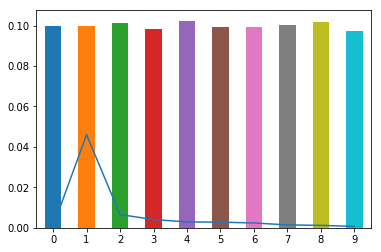

In [479]:
score_fb_ = score_fb(train_m7)
score_fb_['bin_rate'].astype('float64').plot(kind = 'bar')
score_fb_['bad_rate'].astype('float64').plot()

score_fb_['bad_rate'].plot()

In [478]:
score_fb_ = score_fb(train_m7)
score_fb_

,var_name,value,value_,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate
0,score_bin,774.0,0,44165,44135,30,0.0995871300010598,0.0006792709158836182
1,score_bin,563.0,1,44344,42300,2044,0.09999075495906251,0.04609417283059715
2,score_bin,600.0,2,45018,44723,295,0.10151054949366489,0.006552934381802835
3,score_bin,621.0,3,43622,43444,178,0.09836272579885046,0.0040805098344871855
4,score_bin,638.0,4,45419,45287,132,0.1024147595951123,0.00290627270525551
5,score_bin,652.0,5,44015,43892,123,0.09924889679602959,0.0027945018743610133
6,score_bin,665.0,6,44029,43924,105,0.09928046522849908,0.002384791841740671
7,score_bin,678.0,7,44549,44485,64,0.10045300700593712,0.0014366203506251543
8,score_bin,692.0,8,45114,45060,54,0.10172701874488423,0.0011969676818725894
9,score_bin,708.0,9,43206,43176,30,0.09742469237690002,0.0006943480072212193


## 合并所有账龄p,score

In [943]:
train1 = train_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train1

,zl,p,score,default,o_total_amount,return_amt,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest
6,1,0.327889,270.0,0,4635.24,NaN,37,1.000000,1.000000,516,0.128886,279.56
17,2,0.314763,274.0,0,4885.41,NaN,80,1.000000,1.000000,488,0.925753,233.22
57,2,0.296366,280.0,0,19530.17,NaN,64,1.000000,1.000000,428,0.168351,1630.42
63,2,0.347449,263.0,0,6467.35,NaN,2,1.000000,1.000000,308,0.279319,1430.86
103,1,0.288256,283.0,0,4735.01,NaN,52,1.000000,1.000000,273,0.114459,1066.59
120,1,0.290379,282.0,0,4493.69,NaN,42,1.000000,1.000000,28,0.144436,910.39
149,2,0.304316,277.0,0,10746.85,NaN,80,1.000000,1.000000,427,0.399379,1502.40
169,1,0.283697,285.0,0,6922.96,NaN,52,0.000000,0.000000,28,0.059486,1429.91
197,2,0.298359,279.0,0,7864.31,34.12,78,1.000000,1.000000,339,0.491263,1554.35
220,2,0.347851,263.0,1,4173.59,4100.00,2,1.000000,1.000000,354,0.167621,525.00


In [973]:
train2 = train_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train2

,zl,p,score,default,o_total_amount,return_amt,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest
0,5,0.032299,463.0,0,11250.87,NaN,152,1.000000,1.000000,462,1.576903,560.45
7,5,0.032175,463.0,0,17800.31,NaN,100,0.750000,0.800000,195,3.075792,2133.84
9,6,0.031794,464.0,0,26208.06,NaN,123,1.000000,1.000000,399,3.567016,1708.85
30,6,0.031853,464.0,0,16092.02,NaN,189,1.000000,1.000000,471,3.424715,1762.11
31,4,0.035399,456.0,0,10273.75,NaN,68,1.000000,1.000000,318,1.698343,2042.20
43,3,0.048332,433.0,0,7569.27,NaN,65,1.000000,1.000000,276,0.339193,1256.52
44,6,0.034249,459.0,0,18085.70,NaN,182,1.000000,1.000000,478,4.809651,876.35
46,3,0.036427,454.0,0,13515.15,NaN,93,1.000000,1.000000,156,1.069186,2078.01
53,6,0.034249,459.0,0,19649.59,NaN,159,1.000000,1.000000,531,2.657618,605.26
62,4,0.035701,456.0,0,14567.86,NaN,79,1.000000,1.000000,428,1.559696,2575.62


In [972]:
train_m36

,default,zl,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,o_total_amount,return_amt,score,p
0,0,5,152,1.000000,1.000000,462,1.576903,560.45,11250.87,NaN,463.0,0.032299
7,0,5,100,0.750000,0.800000,195,3.075792,2133.84,17800.31,NaN,463.0,0.032175
9,0,6,123,1.000000,1.000000,399,3.567016,1708.85,26208.06,NaN,464.0,0.031794
30,0,6,189,1.000000,1.000000,471,3.424715,1762.11,16092.02,NaN,464.0,0.031853
31,0,4,68,1.000000,1.000000,318,1.698343,2042.20,10273.75,NaN,456.0,0.035399
43,0,3,65,1.000000,1.000000,276,0.339193,1256.52,7569.27,NaN,433.0,0.048332
44,0,6,182,1.000000,1.000000,478,4.809651,876.35,18085.70,NaN,459.0,0.034249
46,0,3,93,1.000000,1.000000,156,1.069186,2078.01,13515.15,NaN,454.0,0.036427
53,0,6,159,1.000000,1.000000,531,2.657618,605.26,19649.59,NaN,459.0,0.034249
62,0,4,79,1.000000,1.000000,428,1.559696,2575.62,14567.86,NaN,456.0,0.035701


In [948]:
train3 = train_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train3

,zl,p,score,default,o_total_amount,return_amt,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest
1,20,0.018502,504.0,0,52581.42,NaN,123,0.500000,0.500000,795,26.185332,5193.63
2,30,0.002240,658.0,0,39747.32,NaN,918,0.000000,0.000000,427,27.052476,1213.28
3,22,0.001839,672.0,0,58266.41,NaN,690,0.000000,0.000000,273,18.897241,3224.60
4,7,0.002869,640.0,0,20694.41,NaN,152,0.000000,0.000000,158,3.785940,3596.70
5,45,0.001638,680.0,0,73483.39,NaN,1384,0.000000,0.000000,7,58.830162,7887.30
8,7,0.007135,574.0,0,27590.05,NaN,233,1.000000,1.000000,212,5.606728,3108.15
10,39,0.004826,602.0,0,63359.17,NaN,1412,1.000000,1.000000,278,21.334045,5317.00
11,23,0.002166,660.0,0,77425.65,NaN,607,0.000000,0.000000,486,27.898197,5995.59
12,9,0.005583,592.0,0,17487.28,NaN,280,1.000000,1.000000,0,7.522994,3766.77
13,43,0.001922,669.0,0,27079.12,NaN,1329,0.000000,0.000000,274,28.658374,1401.19


In [974]:
train = pd.concat([train1,train2,train3])

In [975]:
print(train.shape)
#print(train['default'].value_counts(normalize=True))
a = train['default'].value_counts(normalize=True)[1]
a

(519473, 12)


0.01521542024320802

In [852]:
for row in range(len(train)+1):
    def data(datain):
        if datain['zl'][row] == 1:
            datain['label'][row]='M1'
        else:
            datain['label'][row]='M3'


In [976]:
train.to_csv('train.csv')

In [814]:
def zl_ks(datain):
    ks = stats.ks_2samp(datain.p[datain.default==1],datain.p[datain.default!=1]).statistic
    return ks

In [978]:
zl_ks(train)

0.6590909866575991

In [979]:
pct_rank_qcut(train,'score',15)

In [980]:
score_fb_ = score_fb(train,'score','score_bin')
score_fb_.to_csv('train_score.csv')

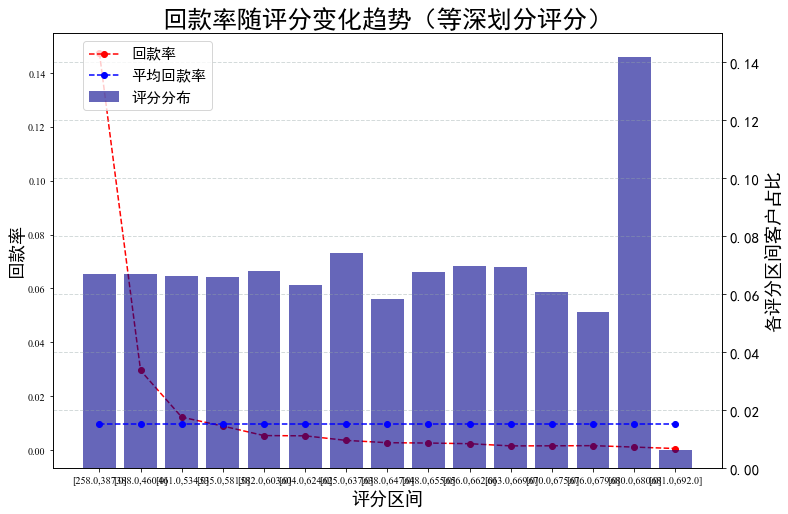

In [981]:
plot_fb(score_fb_,0.15)

In [956]:
test1 = test_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [957]:
test2 = test_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [958]:
test3 = test_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [959]:
test = pd.concat([test1,test2,test3])

In [987]:
test.to_csv('test.csv')

In [977]:
zl_ks(test)

0.6488703977651358

In [953]:
valid1 = oot_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [954]:
valid2 = oot_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [955]:
valid3 = oot_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]

In [982]:
oot_ = pd.concat([valid1,valid2,valid3])

In [1018]:
oot_.to_csv('oot_.csv')

In [985]:
a = oot_['default'].value_counts(normalize=True)[1]
a

0.011369007714242462

In [983]:
zl_ks(oot_)

0.6225366945098076

In [984]:
pct_rank_qcut(oot_,'score',15)

In [986]:
score_fb_ = score_fb(oot_,'score','score_bin')
score_fb_.to_csv('oot_score.csv')

In [1016]:
data = pd.concat([train,test])
data.to_csv('model_xgb.csv')

In [1019]:
oot.shape

(647374, 226)